In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

TensorFlow 2.x selected.


In [1]:
!wget pollithy.com/Pfeffer.zip
!unzip -q Pfeffer.zip

--2020-01-11 11:19:23--  http://pollithy.com/Pfeffer.zip
Resolving pollithy.com (pollithy.com)... 87.118.94.85
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pollithy.com/Pfeffer.zip [following]
--2020-01-11 11:19:23--  https://pollithy.com/Pfeffer.zip
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11741795 (11M) [application/zip]
Saving to: ‘Pfeffer.zip’

Pfeffer.zip         100%[===================>]  11.20M  10.7MB/s    in 1.0s    

2020-01-11 11:19:24 (10.7 MB/s) - ‘Pfeffer.zip’ saved [11741795/11741795]



In [204]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K

# custom modules
import data_manager
import model

print('Tensorflow version:', tf.__version__)
print('GPU support:', tf.test.is_gpu_available())
plt.rcParams['figure.figsize'] = [10, 5]

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.1.0-rc1
GPU support: True


In [206]:
import importlib
importlib.reload(data_manager)

<module 'data_manager' from '/content/data_manager.py'>

timesteps=359
longest_track= 29


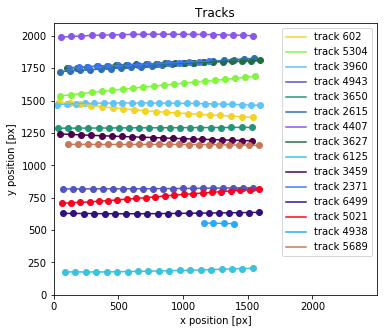

In [207]:
num_time_steps = 40
nan_value = 0
batch_size = 64

csv_data_set = data_manager.CsvDataSet('Pfeffer/trackSortResultPfeffer/*_trackHistory_NothingDeleted.csv',
                              nan_value=nan_value, batch_size=batch_size)

dataset_train, dataset_test = csv_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

csv_data_set.plot_random_tracks(n=15)

In [188]:
track_data, spatial_labels, temporal_labels = csv_data_set.get_separation_prediction_data()
track_data.shape, spatial_labels.shape, temporal_labels.shape

((6739, 29, 2), (6739, 2), (6739,))

In [0]:
def train_step_generator(model, optimizer, batch_size, num_time_steps, nan_value=0):
    # the placeholder character used for padding
    mask_value = K.variable(np.array([nan_value, nan_value]), dtype=tf.float64)
    no_loss_mask_np = np.ones([batch_size, num_time_steps])
    # no_loss_mask_np[:, :7] = 0
    no_loss_mask = tf.constant(no_loss_mask_np)

    @tf.function
    def train_step(inp, target):
        with tf.GradientTape() as tape:
            target = K.cast(target, tf.float64)
            predictions = model(inp)

            mask = K.all(K.equal(inp, mask_value), axis=-1)
            mask = 1 - K.cast(mask, tf.float64)
            mask = K.cast(mask, tf.float64)
           
            # don't use the loss at every time step
            # mask *= no_loss_mask
            loss = tf.keras.losses.mean_squared_error(target, predictions) * mask

            # take average w.r.t. the number of unmasked entries
            loss = K.sum(loss) / K.sum(mask)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        return loss

    return train_step

In [214]:
time_normalization = 22.

dataset_train, dataset_test, num_time_steps = csv_data_set.get_tf_data_sets_seq2seq_with_separation_data(normalized=True,
                                                                                                         time_normalization=time_normalization)

rnn_model, hash_ = model.rnn_model_factory(
        num_units_first_rnn=1024, 
        num_units_second_rnn=16,
        num_units_first_dense=0,
        rnn_model_name='lstm',
        num_time_steps=num_time_steps, 
        batch_size=batch_size,
        nan_value=nan_value, 
        input_dim=2,
        output_dim=4
        )
print(rnn_model.summary())

optimizer = tf.keras.optimizers.Adam()
# train_step_fn = model.train_step_generator(rnn_model, optimizer)
train_step_fn = train_step_generator(rnn_model, optimizer, batch_size, num_time_steps)

total_num_epochs = 400

for epoch in range(total_num_epochs):
  if (epoch+1) % 100 == 0:
      old_lr = K.get_value(optimizer.lr)
      new_lr = old_lr * 0.1
      print("Reducing learning rate from {} to {}.".format(old_lr, new_lr))
      K.set_value(optimizer.lr, new_lr)

  for (batch_n, (inp, target)) in enumerate(dataset_train):
      _ = rnn_model.reset_states()
      loss = train_step_fn(inp, target)

  print("{}/{}: \t loss={}".format(epoch, total_num_epochs, loss))



longest_track= 29
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (64, 29, 2)               0         
_________________________________________________________________
rnn-0 (LSTM)                 (64, 29, 1024)            4206592   
_________________________________________________________________
rnn-1 (LSTM)                 (64, 29, 16)              66624     
_________________________________________________________________
dense_1 (Dense)              (64, 29, 4)               68        
Total params: 4,273,284
Trainable params: 4,273,284
Non-trainable params: 0
_________________________________________________________________
None
0/400: 	 loss=0.010009070796482495
1/400: 	 loss=0.0033580724961326945
2/400: 	 loss=0.0016129723741798792
3/400: 	 loss=0.0016697751034334143
4/400: 	 loss=0.0010069673078178718
5/400: 	 loss=0.0007469542197457186
6/40

KeyboardInterrupt: ignored

In [215]:
# Evaluate

spatial_errors = np.array([])
time_errors = np.array([])

for input_batch, target_batch in dataset_test:
  # reset state
  hidden = rnn_model.reset_states()

  batch_predictions = rnn_model(input_batch).numpy()

  # signed error
  batch_difference = (batch_predictions - target_batch).numpy()
  spatial_diff = (batch_difference[:, -1, 2] * csv_data_set.belt_width).flatten()
  temporal_diff = (batch_difference[:, -1, 3] * time_normalization).flatten()

  spatial_errors = np.concatenate((spatial_errors, spatial_diff))
  time_errors = np.concatenate((time_errors, temporal_diff))

print("Spatial Mean={}".format(np.mean(spatial_errors)))
print("Time Mean={}".format(np.mean(time_errors)))

Spatial Mean=-1.7896247172876216
Time Mean=0.11522045542074873


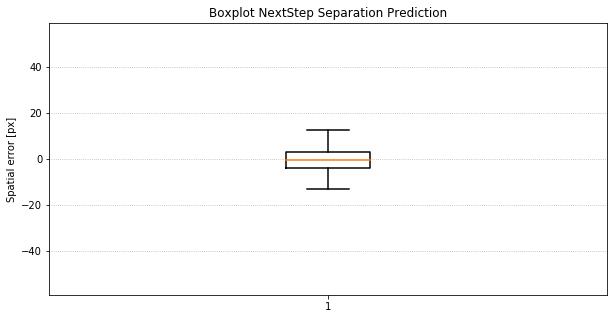

In [216]:
plt.rc('grid', linestyle=":")
fig1, ax1 = plt.subplots()
ax1.yaxis.grid(True)
ax1.set_ylim([-59, 59]) 
ax1.set_title('Boxplot NextStep Separation Prediction')
plt.ylabel('Spatial error [px]')
prop = dict(linewidth=1.5)
ax1.boxplot(spatial_errors, showfliers=False, boxprops=prop, whiskerprops=prop, medianprops=prop, capprops=prop)
plt.show()

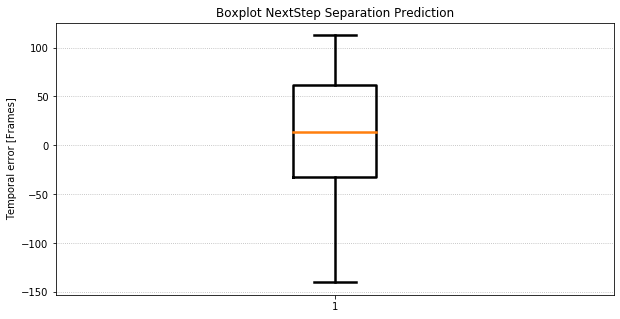

In [217]:
plt.rc('grid', linestyle=":")
fig1, ax1 = plt.subplots()
ax1.yaxis.grid(True)
#ax1.set_ylim([0,4.0]) 
ax1.set_title('Boxplot NextStep Separation Prediction')
plt.ylabel('Temporal error [Frames]')
prop = dict(linewidth=2.5)
ax1.boxplot(time_errors*100, showfliers=False, boxprops=prop, whiskerprops=prop, medianprops=prop, capprops=prop)
plt.show()